In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("default")

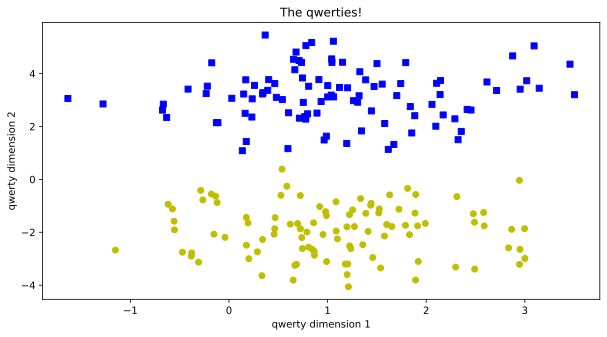

In [6]:
n_per_clust = 100 #número de datos que habrán alrededor de cada centro de categoría
blur = 1 #std, indica cómo de "dispersos" estarán los datos

#coordenadas de la nube de datos de cada categoría (solo eje x)
A = [  1, 3 ] #el centro de la categoría A (x=1,y=1)
B = [  1, -2 ] #el centro de la categoría B (x=5,y=1)

# generar datos aleatorios o "ruido" alrededor de cada centro (A,B)
a = [ A[0]+np.random.randn(n_per_clust)*blur , A[1]+np.random.randn(n_per_clust)*blur ]
b = [ B[0]+np.random.randn(n_per_clust)*blur , B[1]+np.random.randn(n_per_clust)*blur ]

# true labels
#para las etiquetas, asignamos ceros a la categoría A, y 1 a la categoría B
labels_np = np.vstack((np.zeros((n_per_clust,1)),np.ones((n_per_clust,1))))

# concatenamos los datos aleatorios en una matriz traspuesta
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(10,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'yo')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [16]:
import torch.nn.functional as F

In [17]:
class Model(nn.Module):

  def __init__(self):

    super().__init__()

    self.inp = nn.Linear(2, 16)

    self.hid1 = nn.Linear(16, 1)
    self.bnorm1 = nn.BatchNorm1d(16) #batch norm para la primera capa oculta

    self.out = nn.Linear(1, 1)


  def forward(self, x, bnorm):
    #el parámetro booleano bnorm indica si se aplica o no batch norm (si esta entrenándose)

    x = F.relu(self.inp(x)) #los valores que toma la capa de entrada ya están normalizados

    if bnorm:

      x = self.bnorm1(x) #batch norm
      x = F.relu(self.hid1(x))


    else:
      #aplicamos una propagación adelante corriente
      x = F.relu(self.hid1(x))

    return F.sigmoid(self.out(x))

![image.png](attachment:d21cf390-7f8a-4afe-b063-2898b8947fcc.png)

In [18]:
def build_model(learning_rate):

    #arquitectura
    # model = nn.Sequential(

    #     nn.Linear(2,16), #entrada=2, output=16 nodos (CAPA DE ENTRADA)
    #     nn.ReLU(), #función no-lineal a la suma lineal ponderada
    #     nn.BatchNorm1d(16),
    #     nn.Linear(16,1), #entrada=16 nodos, salida=1 nodo (CAPA OCULTA)
    #     nn.ReLU(), #función no-lineal a la suma lineal ponderada
    #     nn.Linear(1,1), #entrada=1, salida=1 predicción (CAPA DE SALIDA)
    #     nn.Sigmoid() #función no-lineal logística para la salida

    # )

    model = Model()


    loss_func = nn.BCELoss() #preferible usar BCEWithLogitLoss(), por lo que no haría falta explícitamente definir Sigmoid() en la última capa

    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

    return model, loss_func, optimizer

### - Función que entrena cada modelo

In [11]:
from tqdm import tqdm

#### Nota: Esta vez, para binarizar la salida, si buscamos aquellos valores > 0.5, ya que explícitamente implementamos la función sigmoide en la última capa, dándonos salidas logísticas. En un caso donde usaráramos `BCELogitsWithLoss()` como pérdida, no habríamos usado la función sigmoide en la última capa, ya que se implementa internamente, pero las salidas serían lineales sin la función sigmoide

In [19]:
n_epochs = 1000

def train(model, progress_bar=True):

    losses = torch.zeros(n_epochs) #para almacenar las pérdidas para cada epoch

    iterator = tqdm(range(n_epochs)) if progress_bar else range(n_epochs)

    for epoch in iterator:

        model.train()

        #forward pass
        y_hat = model(data, True)

        #compute error
        loss = loss_func(y_hat, labels)
        losses[epoch] = loss

        #backward pass
        optim.zero_grad() #clear previous gradients cache
        loss.backward() #compute gradients based on the error
        optim.step() #update parameters

    model.eval()
    #"final forward pass" - post entrenamiento
    preds = model(data, False)

    #categorizamos las predicciones de salida sigmoide del modelo a 0s y 1s
    #(validamos las predicciones que sean mayor a 0.5, y las comparamos con las etiquetas reales creando un vector de booleanos)
    #resultando en ceros y unos dependiendo si el modelo acertó o no, aplicamos la media a esto, y lo convertimos en porcentaje
    total_acc = 100*torch.mean(((preds>0.5) == labels).float()) #ya no es >0, sino >0.5 debido a no usar BCELogitWithLoss()

    return losses, preds, total_acc

### - Antes de poner en marcha el experimento paramétrico, testeamos el código una vez

100%|██████████| 1000/1000 [00:01<00:00, 895.65it/s]


Final Accuracy: 92.0 %


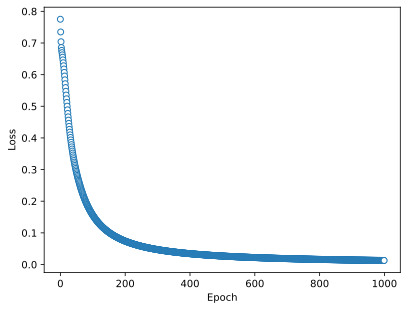

In [20]:
#creamos los objetos necesarios
model, loss_func, optim = build_model(learning_rate=0.1)

#ejecutar el modelo
losses, preds, total_acc = train(model)

#visualizar la precisión
print(f"Final Accuracy: {total_acc} %")

#visualizar la pérdida durante las epochs
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

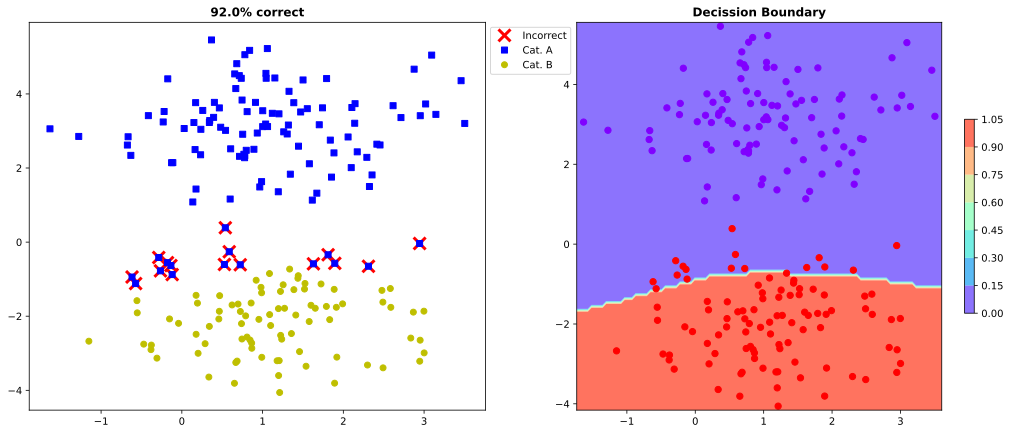

In [21]:
pred_labels = preds > 0.5
misclassified = np.where(pred_labels != labels)[0]
# plot the labeled data
# fig = plt.figure(figsize=(15,7))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,7))



#generamos "X" para la categoria A,B, indexando en los índices donde el modelo no acertó
axs[0].plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=12,markeredgewidth=3)


#usando el operador "~" invertimos los resultados (si indexamos por los pred_labels, obtenemos los puntos con probabilidad > 0.5, categoria B)
#pero como deseamos trazar los de la categoria A, buscamos las que no son 0.5
axs[0].plot(data[np.where(~pred_labels)[0],0],data[np.where(~pred_labels)[0],1],'bs') #trazamos los puntos indexados para las predicciones de la categoria A

axs[0].plot(data[np.where(pred_labels)[0],0] ,data[np.where(pred_labels)[0],1], 'yo') #y por último, trazamos los de la categoría B (usando [filas, col])

axs[0].legend(['Incorrect','Cat. A','Cat. B'],bbox_to_anchor=(1,1))
axs[0].set_title(f'{total_acc}% correct', fontweight="bold")

x_min, x_max = data[:, 0].min() - 0.1, data[:,0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))

x_in = np.c_[xx.ravel(), yy.ravel()]

x_in = torch.tensor(np.array([x_in])).float()

y_pred = model(x_in, False)

y_pred = np.round(y_pred.detach()).reshape(xx.shape)
# plt.figure(figsize=(15,7));
im = axs[1].contourf(xx, yy, y_pred, cmap="rainbow", alpha=0.7 ); #rainbow / cmap=plt.cm.binary_r
axs[1].scatter(data[:,0], data[:, 1], c=labels, s=40, cmap="rainbow"); #rainbow / cmap="Paired"
axs[1].set_xlim(xx.min(), xx.max());
axs[1].set_ylim(yy.min(), yy.max());
axs[1].set_title("Decission Boundary", fontweight="bold")
# axs[1].set_colorbar(shrink=0.5);
fig.colorbar(im, ax=axs[1], shrink=0.5)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.show()

In [ ]:
plt.

_____________

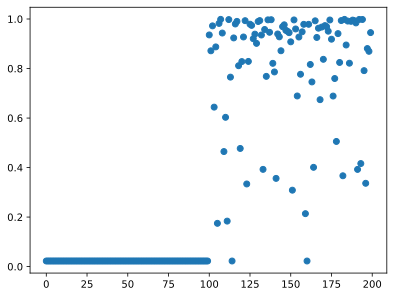

In [22]:
plt.plot(preds.detach(), "o");

________